---
# Training of the recognition network that forms the feature extractor of the encoding model
---

In [3]:
import sys
import os
import struct
import time
import numpy as np
import h5py
import scipy.io as sio
from scipy import ndimage as nd
from scipy import misc
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
import seaborn as sns
%matplotlib inline

import theano
import theano.tensor as T

import lasagne
import lasagne.layers as L
import lasagne.regularization as R
import lasagne.nonlinearities as NL
import lasagne.objectives as O
import lasagne.init as I

import fwrf.src.numpy_utility as pnu
import fwrf.src.lasagne_utility as plu
from fwrf.src.load_data import load_stimuli, load_voxels
from src.load_images import load_cifar10

In [4]:
fpX = np.float32
print "theano floatX: %s" % theano.config.floatX
print "numpy floatX: %s" % fpX

sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

theano floatX: float32
numpy floatX: <type 'numpy.float32'>


In [5]:
cwd = os.getcwd() + '/'
output_dir  = cwd + "output/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

print "Current dir: %s" % cwd
print "Time Stamp: %s" % timestamp

Current dir: /home/styvesg/Documents/PostDoc/GitRepo/gan-imaging/
Time Stamp: Jul-05-2018_1727


In [6]:
saveext = ".pdf"
savearg = {'format':'pdf', 'dpi': 200}

# 1) Load CIFAR-10 dataset 

In [7]:
cifar_root = "/home/styvesg/Documents/PostDoc/Datasets/cifar-10/"

In [8]:
input_data, label_data, label_map, input_trn_size = load_cifar10(cifar_root)

input_data_size = len(input_data)
input_trn_size = input_data_size - 500
val_size = input_data_size - input_trn_size

input_data -= 0.5
trn_input_data = input_data[:input_trn_size]
val_input_data = input_data[input_trn_size:] 

trn_label_data = label_data[:input_trn_size]
val_label_data = label_data[input_trn_size:]

loading data_batch_1...
loading data_batch_2...
loading data_batch_3...
loading data_batch_4...
loading data_batch_5...
loading test_batch...


In [9]:
print np.min(trn_input_data)
print trn_input_data.shape
print input_trn_size

-0.5
(59500, 3, 32, 32)
59500


In [10]:
print label_map

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
npc = input_data.shape[1]         # # of channels in image
npx = input_data.shape[2]         # # of pixels width/height of images 
nx = npx*npx*npc   # # of dimensions in X
ny = len(label_map)   # # of classes
print npc, npx, nx, ny

3 32 3072 10


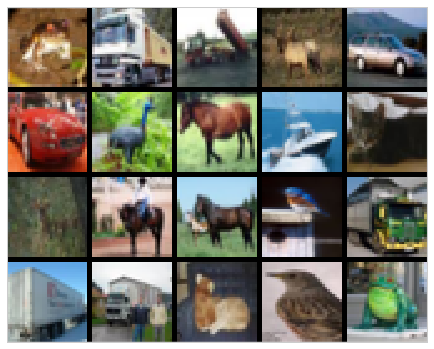

In [12]:
plt.figure(figsize=(10,6))
plt.imshow(pnu.mosaic_vis(input_data[:20,...].transpose(0,2,3,1), pad=2), interpolation='None')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# 2)  Define and train the classifier
This may not be entirely necessary. There are dozens of trained classification networks out there and we don't need this net to be of the same input size or trained on the same set as we would the GAN

In [81]:
from net.cifar10_definitions import cls_net, cls_net_str

_X = T.tensor4()
_Y = T.matrix()

cls_input = L.InputLayer(shape=(None, npc, npx, npx), input_var=_X, name='X')
aux, cls = cls_net(cls_input)

plu.print_lasagne_network(cls, skipnoparam=True)
print cls_net_str

Layer	: <lasagne.layers.input.InputLayer object at 0x7f11c4109310>
Name	: X
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 3, 32, 32)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7f11c40ff990>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 128, 16, 16)
Params
        |-- W         : (128, 3, 4, 4)
        |-- b         : (128,)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7f11c40f57d0>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 256, 8, 8)
Params
        |-- W         : (256, 128, 4, 4)


Layer	: <lasagne.layers.normalization.BatchNormLayer object at 0x7f11c475c6d0>
Name	: None
Type	: <class 'lasagne.layers.normalization.BatchNormLayer'>
Shape	: (None, 256, 8, 8)
Params
        |-- mean      : (256,)
        |-- inv_std   : (256,)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7f11c4003550>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 384, 6, 6)
Param

In [82]:
_lr = theano.shared(fpX(0.0))
_l2 = theano.shared(fpX(0.0))

_cls_reg = _l2 * R.regularize_layer_params(cls, R.l2)
cls_params = L.get_all_params(cls, trainable=True)
print cls_params
###
_cls_trn_pred = L.get_output(cls, deterministic=False)
#_cls_trn_loss = O.squared_error(_cls_trn_pred, Y).mean() + _cls_reg
_cls_trn_loss = O.categorical_crossentropy(_cls_trn_pred, _Y).mean() + _cls_reg

_cls_val_pred = L.get_output(cls, deterministic=True)
_cls_val_loss = O.categorical_crossentropy(_cls_val_pred, _Y).mean()
_cls_val_acc = O.categorical_accuracy(_cls_val_pred, _Y, top_k=1).mean()
#T.mean(T.eq(T.argmax(_cls_val_pred, axis=1), T.argmax(Y, axis=1)), dtype=theano.config.floatX)

_class = T.extra_ops.to_one_hot(T.argmax(_cls_val_pred, axis=1), ny)
_fmaps = [L.get_output(a, deterministic=True) for a in aux]

cls_updates = lasagne.updates.adam(_cls_trn_loss, cls_params, learning_rate=_lr, beta1=0.5, epsilon=1e-12) 

print 'COMPILING'
t = time.time()
cls_trn_fn = theano.function([_X, _Y], [_cls_trn_loss, _cls_val_acc], updates=cls_updates)
cls_val_fn = theano.function([_X, _Y], [_cls_val_loss, _cls_val_acc])
cls_pred_fn = theano.function([_X], _fmaps+[_class,])
print '%.2f seconds to compile theano functions'%(time.time()-t)

[W, b, W, W, W, W, W, b]
COMPILING
297.90 seconds to compile theano functions


## Classifier network training

In [23]:
##### train this shit
lr = fpX(1e-3)      # initial learning rate for adam
l2 = fpX(4.0e-3)       # l2 weight decay

niter = 10       # # of iter at starting learning rate
perc_decay = 10.0 # # of iter to linearly decay learning rate to zero
num_epochs = 40
batch_size = 500

_lr.set_value(fpX(lr))
_l2.set_value(fpX(l2))

trn_hist = []
val_hist = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    trn_err = 0
    trn_acc = 0
    trn_batches = 0
    start_time = time.time()
    for xb, yb in tqdm(fwrf.iterate_minibatches(trn_input_data, trn_label_data, batch_size)):
        err, acc = cls_trn_fn(xb, yb)
        trn_err += err
        trn_acc += acc
        trn_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for xb, yb in fwrf.iterate_minibatches(val_input_data, val_label_data, batch_size):
        err, acc = cls_val_fn(xb, yb)
        val_err += err
        val_acc += acc
        val_batches += 1

    trn_hist += [trn_acc / trn_batches,]
    val_hist += [val_acc / val_batches,]
    # Then we print the results for this epoch:
    print("\n  Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:       {:.6f}".format(trn_err / trn_batches))
    print("  validation loss:     {:.6f}".format(val_err / val_batches))    
    print("  training accuracy:   {:.2f} %".format(trn_acc / trn_batches * 100))    
    print("  validation accuracy: {:.2f} %".format(val_acc / val_batches * 100))
    
    if epoch > niter:
        _lr.set_value(fpX(_lr.get_value() * (1.0 - perc_decay / 100.0)))     
    sys.stdout.flush()

100it [00:26,  3.76it/s]


  Epoch 1 of 40 took 26.911s
  training loss:       0.480837
  validation loss:     0.585736
  training accuracy:   88.14 %
  validation accuracy: 80.34 %



100it [00:26,  3.88it/s]


  Epoch 2 of 40 took 26.806s
  training loss:       0.472993
  validation loss:     0.608267
  training accuracy:   89.80 %
  validation accuracy: 79.94 %



100it [00:26,  3.84it/s]


  Epoch 3 of 40 took 26.989s
  training loss:       0.459238
  validation loss:     0.616793
  training accuracy:   90.79 %
  validation accuracy: 79.85 %



100it [00:26,  3.87it/s]


  Epoch 4 of 40 took 26.836s
  training loss:       0.458018
  validation loss:     0.541495
  training accuracy:   90.86 %
  validation accuracy: 82.01 %



100it [00:26,  3.84it/s]


  Epoch 5 of 40 took 26.779s
  training loss:       0.454392
  validation loss:     0.557194
  training accuracy:   90.99 %
  validation accuracy: 81.24 %



100it [00:26,  3.84it/s]


  Epoch 6 of 40 took 26.812s
  training loss:       0.442408
  validation loss:     0.567626
  training accuracy:   91.45 %
  validation accuracy: 80.83 %



100it [00:26,  3.85it/s]


  Epoch 7 of 40 took 26.843s
  training loss:       0.435897
  validation loss:     0.566084
  training accuracy:   91.68 %
  validation accuracy: 81.09 %



100it [00:26,  3.86it/s]


  Epoch 8 of 40 took 26.921s
  training loss:       0.427200
  validation loss:     0.565376
  training accuracy:   92.09 %
  validation accuracy: 80.85 %



100it [00:26,  3.85it/s]


  Epoch 9 of 40 took 27.020s
  training loss:       0.422682
  validation loss:     0.594782
  training accuracy:   92.47 %
  validation accuracy: 80.72 %



100it [00:26,  3.78it/s]


  Epoch 10 of 40 took 26.937s
  training loss:       0.412512
  validation loss:     0.535231
  training accuracy:   92.91 %
  validation accuracy: 82.05 %



100it [00:26,  3.81it/s]


  Epoch 11 of 40 took 26.964s
  training loss:       0.404839
  validation loss:     0.551433
  training accuracy:   92.96 %
  validation accuracy: 81.96 %



100it [00:26,  3.83it/s]


  Epoch 12 of 40 took 27.142s
  training loss:       0.404173
  validation loss:     0.568194
  training accuracy:   93.42 %
  validation accuracy: 81.11 %



100it [00:26,  3.79it/s]


  Epoch 13 of 40 took 27.270s
  training loss:       0.385208
  validation loss:     0.539126
  training accuracy:   93.61 %
  validation accuracy: 82.27 %



100it [00:26,  3.79it/s]


  Epoch 14 of 40 took 27.038s
  training loss:       0.368383
  validation loss:     0.553293
  training accuracy:   94.76 %
  validation accuracy: 82.08 %



100it [00:26,  3.78it/s]


  Epoch 15 of 40 took 26.964s
  training loss:       0.343115
  validation loss:     0.527688
  training accuracy:   95.21 %
  validation accuracy: 82.52 %



100it [00:26,  3.86it/s]


  Epoch 16 of 40 took 26.943s
  training loss:       0.331046
  validation loss:     0.514987
  training accuracy:   95.81 %
  validation accuracy: 83.18 %



100it [00:26,  3.85it/s]


  Epoch 17 of 40 took 26.918s
  training loss:       0.318485
  validation loss:     0.522257
  training accuracy:   96.26 %
  validation accuracy: 83.07 %



100it [00:26,  3.84it/s]


  Epoch 18 of 40 took 26.925s
  training loss:       0.303181
  validation loss:     0.503879
  training accuracy:   96.40 %
  validation accuracy: 83.79 %



100it [00:26,  3.72it/s]


  Epoch 19 of 40 took 27.013s
  training loss:       0.296602
  validation loss:     0.533449
  training accuracy:   96.93 %
  validation accuracy: 82.95 %



100it [00:26,  3.78it/s]


  Epoch 20 of 40 took 26.981s
  training loss:       0.288337
  validation loss:     0.504990
  training accuracy:   97.19 %
  validation accuracy: 83.88 %



100it [00:26,  3.82it/s]


  Epoch 21 of 40 took 26.957s
  training loss:       0.278838
  validation loss:     0.491878
  training accuracy:   97.53 %
  validation accuracy: 83.96 %



100it [00:26,  3.79it/s]


  Epoch 22 of 40 took 27.343s
  training loss:       0.266951
  validation loss:     0.501672
  training accuracy:   97.80 %
  validation accuracy: 84.02 %



100it [00:26,  3.85it/s]


  Epoch 23 of 40 took 26.909s
  training loss:       0.263210
  validation loss:     0.505271
  training accuracy:   97.92 %
  validation accuracy: 83.88 %



100it [00:26,  3.81it/s]


  Epoch 24 of 40 took 26.989s
  training loss:       0.259075
  validation loss:     0.495569
  training accuracy:   98.08 %
  validation accuracy: 84.17 %



100it [00:26,  3.76it/s]


  Epoch 25 of 40 took 27.076s
  training loss:       0.251973
  validation loss:     0.513756
  training accuracy:   98.21 %
  validation accuracy: 83.72 %



100it [00:26,  3.76it/s]


  Epoch 26 of 40 took 27.040s
  training loss:       0.247583
  validation loss:     0.489776
  training accuracy:   98.38 %
  validation accuracy: 84.24 %



100it [00:26,  3.83it/s]


  Epoch 27 of 40 took 27.286s
  training loss:       0.242590
  validation loss:     0.482062
  training accuracy:   98.49 %
  validation accuracy: 84.36 %



100it [00:26,  3.80it/s]


  Epoch 28 of 40 took 26.926s
  training loss:       0.240342
  validation loss:     0.492320
  training accuracy:   98.55 %
  validation accuracy: 84.27 %



100it [00:26,  3.85it/s]


  Epoch 29 of 40 took 27.123s
  training loss:       0.229794
  validation loss:     0.496075
  training accuracy:   98.59 %
  validation accuracy: 84.27 %



100it [00:26,  3.82it/s]


  Epoch 30 of 40 took 26.892s
  training loss:       0.227848
  validation loss:     0.487707
  training accuracy:   98.71 %
  validation accuracy: 84.42 %



100it [00:26,  3.79it/s]


  Epoch 31 of 40 took 27.020s
  training loss:       0.224621
  validation loss:     0.490056
  training accuracy:   98.73 %
  validation accuracy: 84.38 %



100it [00:26,  3.77it/s]


  Epoch 32 of 40 took 26.995s
  training loss:       0.218905
  validation loss:     0.488314
  training accuracy:   98.82 %
  validation accuracy: 84.54 %



100it [00:26,  3.81it/s]


  Epoch 33 of 40 took 26.976s
  training loss:       0.219201
  validation loss:     0.488742
  training accuracy:   98.80 %
  validation accuracy: 84.58 %



100it [00:26,  3.77it/s]


  Epoch 34 of 40 took 26.972s
  training loss:       0.218396
  validation loss:     0.482264
  training accuracy:   98.84 %
  validation accuracy: 84.51 %



100it [00:26,  3.66it/s]


  Epoch 35 of 40 took 26.993s
  training loss:       0.213757
  validation loss:     0.485328
  training accuracy:   98.97 %
  validation accuracy: 84.66 %



100it [00:26,  3.72it/s]


  Epoch 36 of 40 took 27.362s
  training loss:       0.216468
  validation loss:     0.482741
  training accuracy:   98.95 %
  validation accuracy: 84.68 %



100it [00:26,  3.81it/s]


  Epoch 37 of 40 took 27.217s
  training loss:       0.209858
  validation loss:     0.487955
  training accuracy:   98.97 %
  validation accuracy: 84.57 %



100it [00:27,  3.77it/s]


  Epoch 38 of 40 took 27.912s
  training loss:       0.210997
  validation loss:     0.484565
  training accuracy:   99.01 %
  validation accuracy: 84.76 %



100it [00:27,  3.79it/s]


  Epoch 39 of 40 took 27.787s
  training loss:       0.206184
  validation loss:     0.482615
  training accuracy:   99.05 %
  validation accuracy: 84.70 %



100it [00:26,  3.72it/s]


  Epoch 40 of 40 took 27.333s
  training loss:       0.207877
  validation loss:     0.484416
  training accuracy:   99.05 %
  validation accuracy: 84.69 %


# 3) Training results
## History

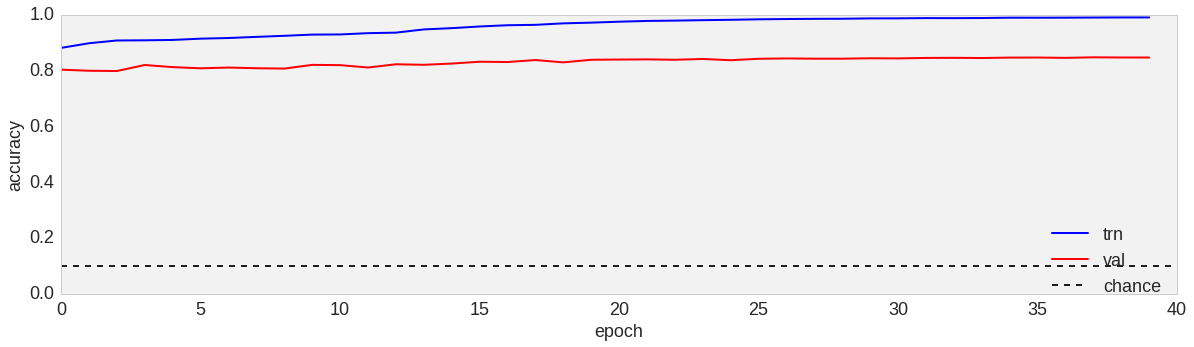

In [24]:
plt.figure(figsize=(20,5))
plt.plot(trn_hist, 'b', label='trn', lw=2)
plt.plot(val_hist, 'r', label='val', lw=2)
plt.axhline(1./ny, color='k', linestyle='--', label='chance')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0.0, 1.0)
plt.legend(bbox_to_anchor=(1., 0.3))
plt.grid()

## First layer filters

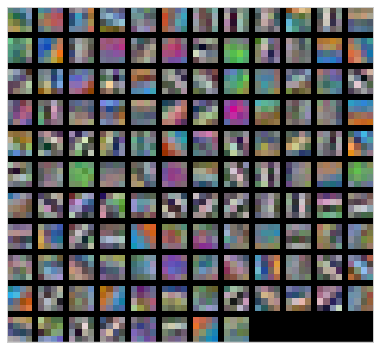

In [85]:
plt.figure(figsize=(10,6))
plt.imshow(pnu.mosaic_vis(cls_params[0].get_value().transpose(0, 2, 3, 1), pad=1), interpolation='None')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

## Partial test accuracy (for future reference)

In [86]:
sample_size = 500
        
real_X = val_input_data[:sample_size,...]
real_Y = val_label_data[:sample_size,...]

inf = cls_pred_fn(real_X)
inf_fmaps, inf_Y = inf[:-1], inf[-1]

print "Classification accuracy = %f" % (np.mean(np.argmax(inf_Y, axis=1)==np.argmax(real_Y, axis=1)))

Classification accuracy = 0.864000


## Save the results

In [17]:
cls_param_file_name = "cifar10-cls-%s-%s.pkl" % (cls_net_str, timestamp)
print cls_param_file_name
cls_param_file = open(output_dir + cls_param_file_name, 'wb')
cls_param_values = L.get_all_param_values(_cls)
pickle.dump(cls_param_values, cls_param_file)
cls_param_file.close()

SyntaxError: invalid syntax (<ipython-input-17-b7af32b18515>, line 1)